# Overview of exercises:
1. Exploring with blurring, thresholds, and morphological operations to identify objects on an uneven background
2. Using the skills from Exercise #1 to segment cell membranes in an image from the early *Drosophila melanogaster* embryo
3. Using the 'analyze particles' functionality in Python to measure sizes and other properties of objects

### Connecting to Google Drive and installing libraries

In [ ]:
# Connect to Google drive to access required data and images
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# The first two lines (the two '%pip install' ones) used to be necessary for this to work, but aren't any more.
# If you receive an error running this cell, try uncommenting them and running the cell again.
# %pip install wheel
# %pip install plotly==5.4.0

import numpy as np
import plotly.express as px     # Useful plotting functions
import cv2                      # OpenCV, one of several image processing / computer vision libraries
import matplotlib.pyplot as plt # More plotting functions
from skimage import measure     # Several more functions for image processing

%matplotlib inline

## Exercise set #1 - Introduction to thresholding and morphological operations

This exercise set includes:
- Applying a blur and a basic threshold to an image to segment the image (in other words, separate foreground from background)
- Improving the segmentation by subtracting background
- Cleaning up the resulting segmentation with one or more binary morphological operations

### Step one - read in a test image. We'll use a default one from Python

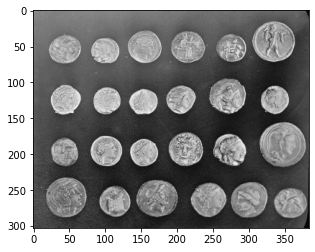

In [ ]:
from skimage import data
img = data.coins() # Grayscale image of some coins
plt.imshow(img,cmap='gray')
plt.show()

In [ ]:
# Get basic information about the image. In reality, this would be known, especially if you acquired the data yourself
print(np.shape(img)) # Image size (height x width - Numpy uses the first dimension as the number of rows and the second as number of columns)
print(img.dtype) # Bit depth and data type - uint8 is an 8-bit integer, for example

(303, 384)
uint8


### Step two - blur and threshold the image to try to segment out the coins. We'll use Otsu's method to threshold

There are several different ways to blur an image. Two of the most common are Gaussian blurs and median filters:
- **Gaussian blur**: Set each pixel to a weighted average of the value of all pixels nearby. The weighting here is accomplished using a Gaussian function such that the pixel itself is weighted highest, with pixels farther away contributing less to the average.
- **Median filter**: Set each pixel to the median of the values of all pixels surrounding it. This is good for removing bright pixels of 'noise' from an image.

[Otsu's method](https://https://en.wikipedia.org/wiki/Otsu%27s_method) is an algorithm for automatically determining a good threshold to binarize an image. It's not always the best threshold for a given application, but using it takes some of the manual guesswork out of thresholding and lets you automate code better.

In [ ]:
# Make a better mask using some preprocessing
gaussBlur = cv2.GaussianBlur(img,(5,5),0) # Leaving the 0 here automatically computes sigma, but you can set manually if preferred
medBlur = cv2.medianBlur(img,5)

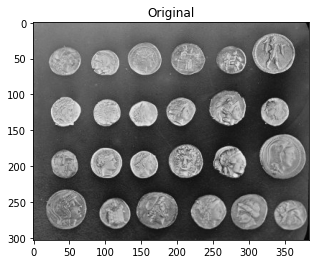

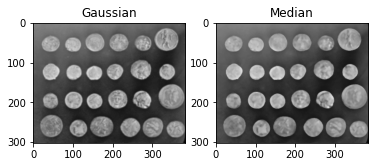

In [ ]:
images = [img, gaussBlur, medBlur]
titles = ['Original', 'Gaussian', 'Median']
# plt.rcParams['figure.figsize'] = [15, 15] # See if this can be automated to fit screen size (or if it already is)
# for i in range(3):
#     plt.subplot(1,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
#     plt.title(titles[i])
#     plt.xticks([]),plt.yticks([])
plt.imshow(images[0],'gray',vmin=0,vmax=255), plt.title(titles[0])
plt.show()
plt.subplot(1,2,1), plt.imshow(images[1],'gray',vmin=0,vmax=255), plt.title(titles[1])
plt.subplot(1,2,2), plt.imshow(images[2],'gray',vmin=0,vmax=255), plt.title(titles[2])
plt.show()

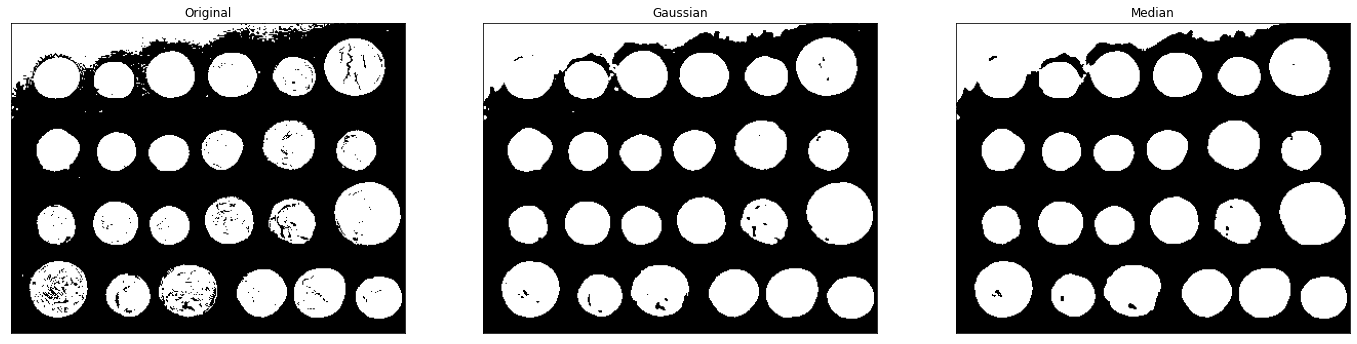

In [ ]:
# Threshold coin image to produce binary image - use Otsu's method to automatically set threshold
thresh, imgBin = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Returns threshold, then mask
gaussthresh, gaussBin = cv2.threshold(gaussBlur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
medthresh, medBin = cv2.threshold(medBlur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

images = [imgBin, gaussBin, medBin]
titles = ['Original', 'Gaussian', 'Median']
plt.rcParams['figure.figsize'] = [24, 24] # See if this can be automated to fit screen size (or if it already is)
for i in range(3):
    plt.subplot(1,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

### Step three - make better masks using a background subtraction prior to the threshold

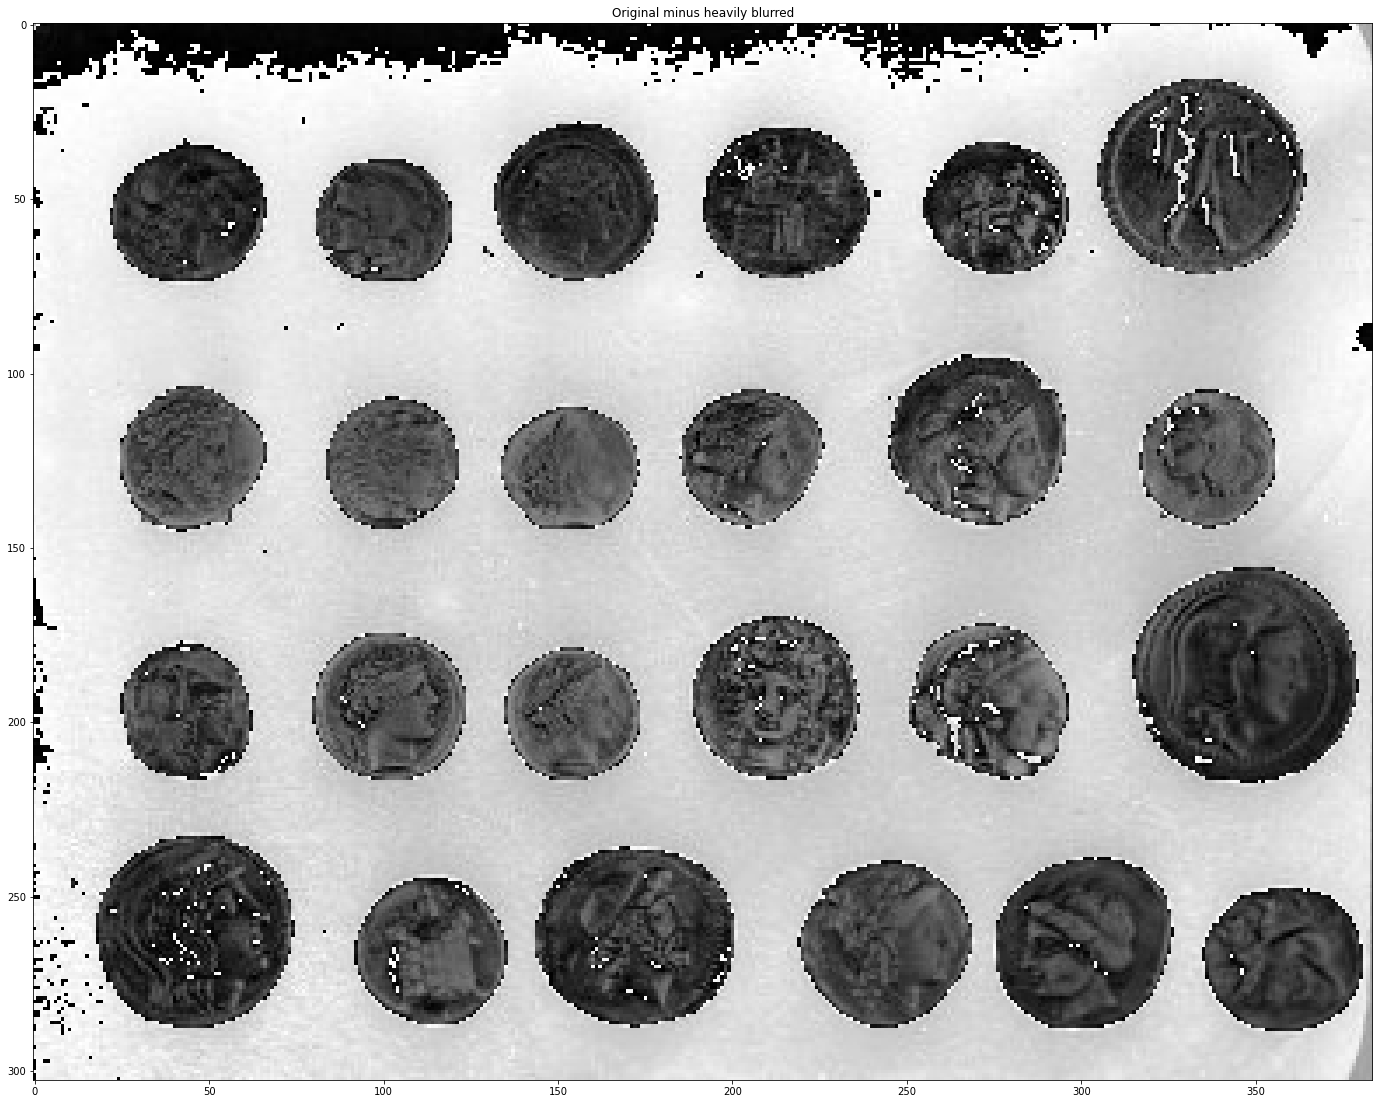

In [ ]:
# Subtract a heavily-blurred version of the image from itself

# Part 1: apply a strong blur to the original image
blurry = cv2.GaussianBlur(img,(201,201),0)

# Part 2: substract that from the original
cleaned = img - blurry

# Part 3: display the results. See if the results match your guess (and don't worry if not - take a look at the next step)
plt.imshow(cleaned,'gray')
plt.title('Original minus heavily blurred')
plt.show()

What happened?

Most often, image data consists of (unsigned) 8-bit integer pixels, meaning each pixel value is an integer from 2<sup>0</sup>-1 = 0 to 2<sup>8</sup>-1 = 255. Because of how math works in binary, negative numbers in unsigned integers are interpreted as very large numbers instead: any time you exceed the 0-255 range with the uint8 data type, you essentially roll over to the other end of the data range.

Because of this, in Python at least, you can get some very surprising results from basic math, like 1 - 2 = 255 or 255 + 1 = 0.

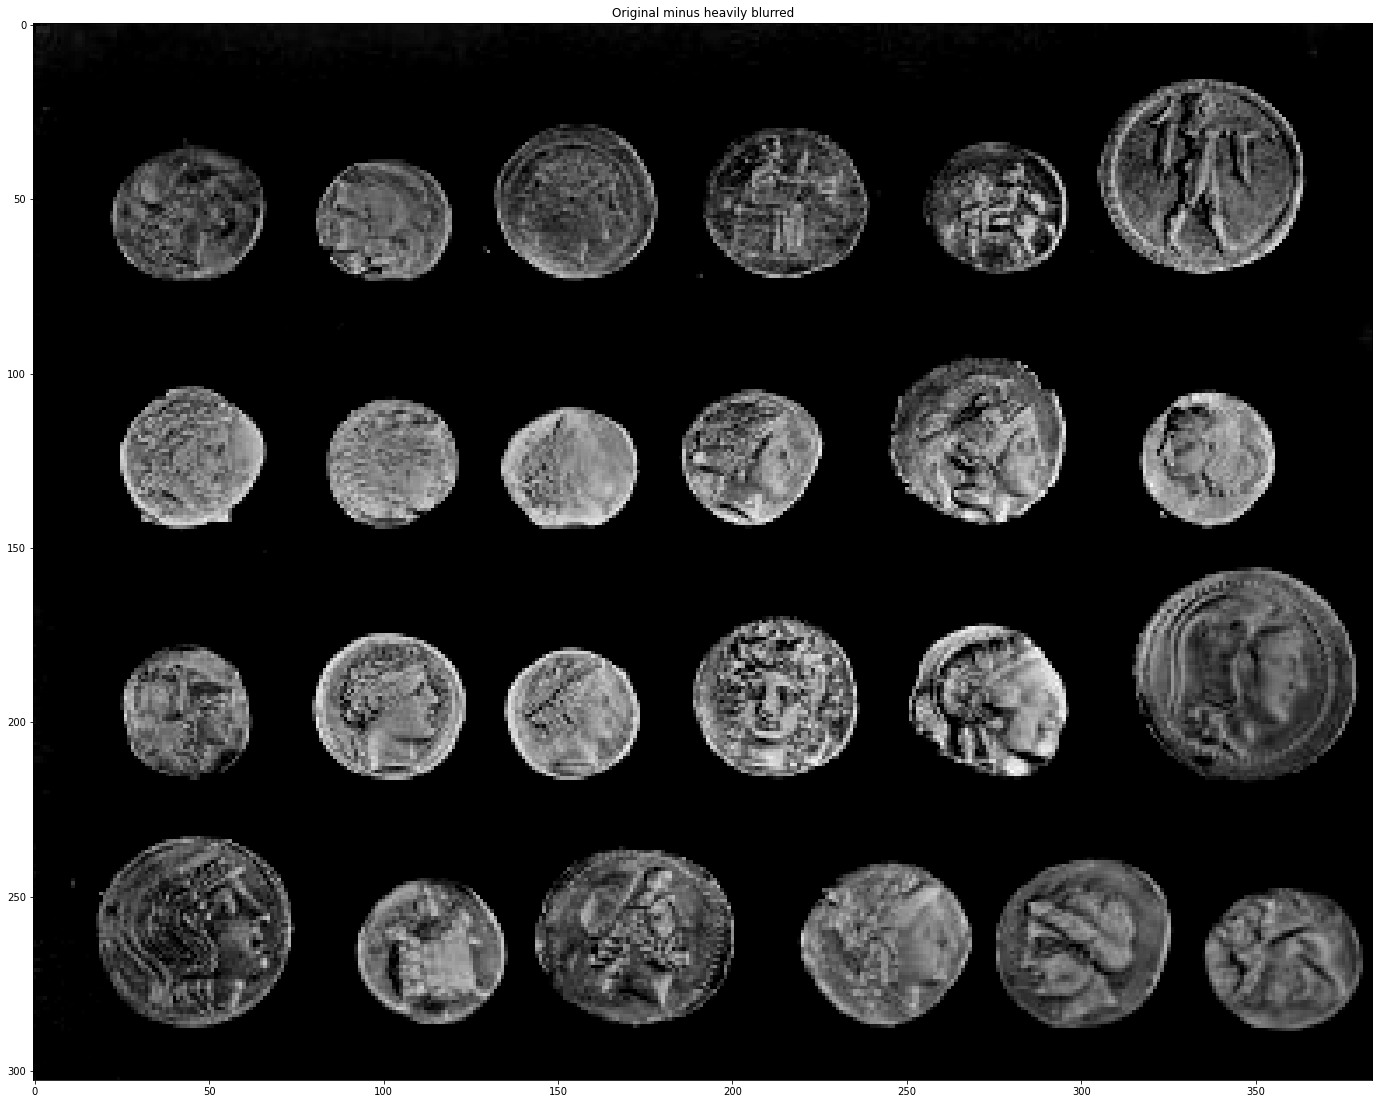

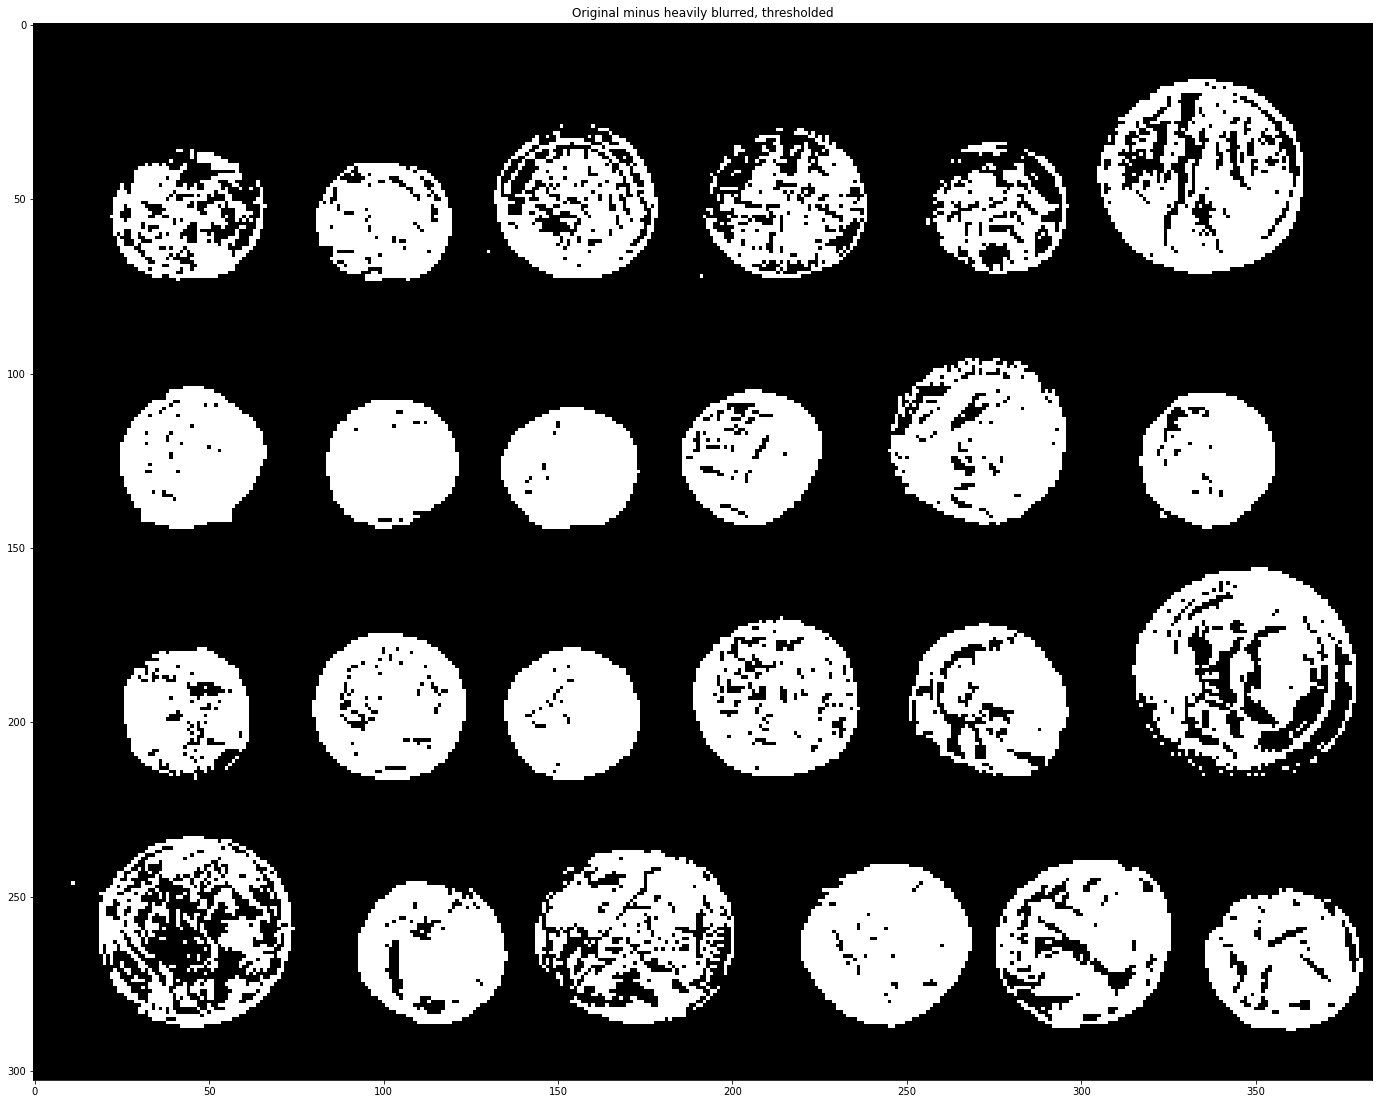

In [ ]:
# Fixing the uint8 quirk: using a cv2 function for subtraction that automatically clips pixel value to 0 if they go 'negative'
cleaned8 = cv2.subtract(img, blurry, np.zeros(np.size(img))) # Arguments: the original image, the image to subtract, and the output destination
plt.autoscale() # Autoscale the plot so the dimmest pixel is displayed as 0 and the brightest as 255.
plt.imshow(cleaned8,'gray')
plt.title('Original minus heavily blurred')
plt.show()

thresh3, imgBin3 = cv2.threshold(cleaned8,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Threshold
plt.imshow(imgBin3,'gray')
plt.title('Original minus heavily blurred, thresholded')
plt.show()

### Step four - use morphological operations to clean up the mask and display the result

As was mentioned in the lecture, a variety of operations known as 'morphological operations' can be used to clean up binary images (they also work in a similar manner on grayscale images  – e.g. 8-bit images with pixel values between 0-255 – but that's beyond the scope of this session). If you're interested in the logic underlying these operations, here's a quick reference: https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/topic4.htm

From the same website, here's a concise summary of why we might want to do this: 

<blockquote>Binary images may contain numerous imperfections. In particular, the binary regions produced by simple thresholding are distorted by noise and texture. Morphological image processing pursues the goals of removing these imperfections by accounting for the form and structure of the image.

Below is a simple example showing the Python / OpenCV syntax for some morphological operations and their effects on a fake 'image'. Your job will be to use these operations to clean up any segmentations you make in this workshop that you think need slight improvement.

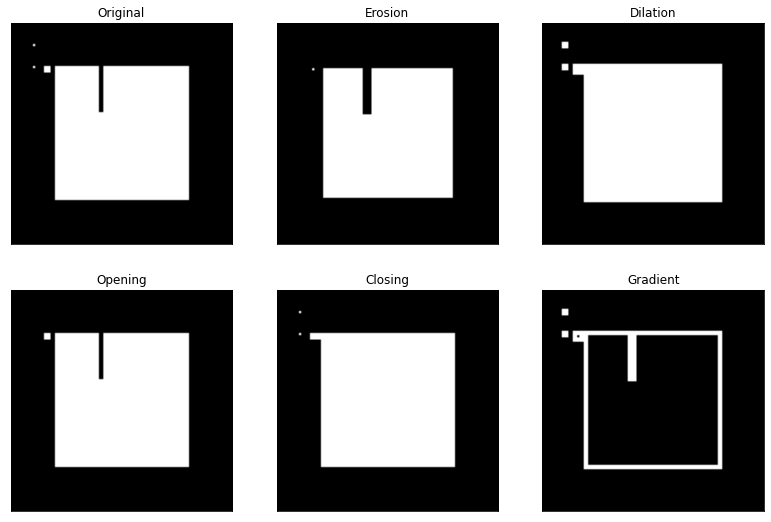

In [ ]:
# SAMPLE MORPHOLOGICAL OPERATIONS (erosion, dilation, opening, closing, gradient)

# Make a structuring element / kernel and the sample image
testKern = np.ones((3,3),np.uint8)

testIm = np.zeros((101,101), np.uint8)
testIm[20:81,20:81] = 255;
testIm[20:41,40:42] = 0;
testIm[10:11,10:11] = 255;
testIm[20:21,10:11] = 255;
testIm[20:23,15:18] = 255;

# Simple operations (erode and dilate)
erode = cv2.morphologyEx(testIm, cv2.MORPH_ERODE, testKern)
dilate = cv2.morphologyEx(testIm, cv2.MORPH_DILATE, testKern)

# Compound operations (open and close)
open = cv2.morphologyEx(testIm, cv2.MORPH_OPEN, testKern)
close = cv2.morphologyEx(testIm, cv2.MORPH_CLOSE, testKern)

# Gradient (edge finding)
grad = cv2.morphologyEx(testIm, cv2.MORPH_GRADIENT, testKern)

# Display results by each other
plt.rcParams['figure.figsize'] = [13.5, 9] # May have to adjust these for different screen sizes
images = [testIm, erode, dilate,
          open, close, grad]
titles = ['Original', 'Erosion', 'Dilation',
          'Opening', 'Closing', 'Gradient']
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

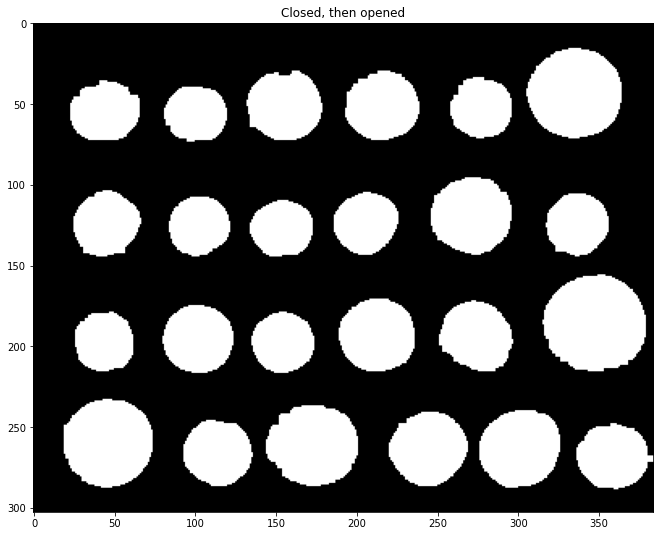

In [ ]:
# Create kernels for morphological operations
openKern = np.ones((3,3),np.uint8)
closeKern = np.ones((7,7),np.uint8)

# Perform combination of operations to improve the segmentation
improved = cv2.morphologyEx(imgBin3, cv2.MORPH_CLOSE, closeKern)
improved = cv2.morphologyEx(improved, cv2.MORPH_OPEN, openKern)
plt.imshow(improved,'gray')
plt.title('Closed, then opened')
plt.show()

### Step five - use the segmentation to 'mask' the original image

Sometimes it's useful (or just a good sanity check) to look only at the pixels corresponding to 'foreground'. To do that, you can use the binary segmentation to keep all foreground pixels and set all others to zero.

This is a simple operation - think about what the values are in the segmentation image, and remember that images are just matrices of numbers and you can do pixel-by-pixel operations using two different images.

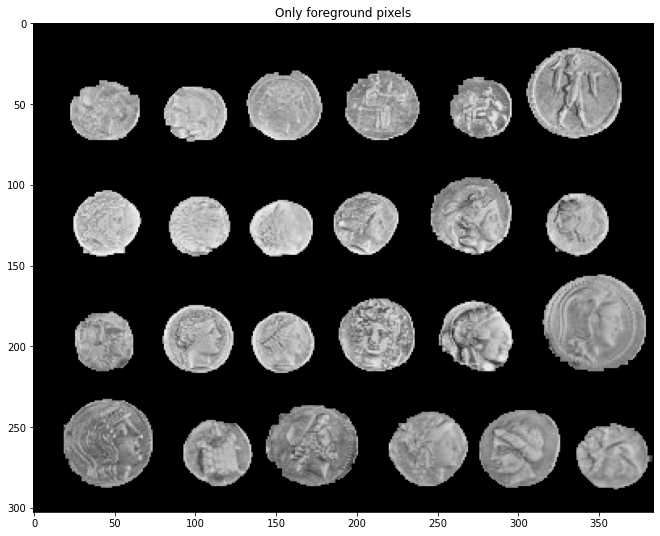

In [ ]:
# Make the masking array (slight modification to the segmentation to make the math easier)
mask = improved/255 # To have values of only zero or one
masked = img*mask # Multiply the two, such that all background values are multiplied by 0 and all foreground are kept the same
plt.imshow(masked,'gray')
plt.title('Only foreground pixels')
plt.show()

## Exercise set #2 - Creating a binary image corresponding to cell outlines in the *Drosophila melanogaster* embryo

This exercise set includes:
- Using what you learned above about thresholding and morphological operations, find cell outlines in an image.
- Repeating the segmentation with a more complicated image from the same embryo.

### Step one - Read in an image with fairly evenly-sized cells

This image has bright cell membranes and dark cell bodies, so it won't work exactly the same way as the coin example above. The main idea is similar, though.

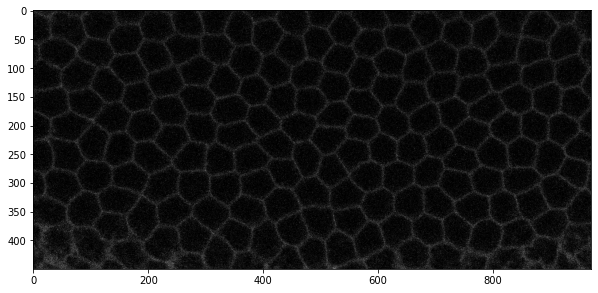

(450, 972)
uint8


In [ ]:
# Read in the image - this is copied from the pre-work
# fname = '/content/gdrive/MyDrive/QMW2023_imageAnalysisWorkshop/embryo_membranes_t1.tif'
fname = '/content/gdrive/MyDrive/QMW2023_imageAnalysisWorkshop/embryo2_membranes_t1.tif'
emb1 = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
plt.autoscale() # Autoscale the plot so the dimmest pixel is displayed as 0 and the brightest as 255.
plt.imshow(emb1,cmap='gray')
plt.gcf().set_size_inches(10, 10)
plt.show()
print(np.shape(emb1))
print(emb1.dtype)

### Step two - use the concepts from the previous example to pick out the cell membranes

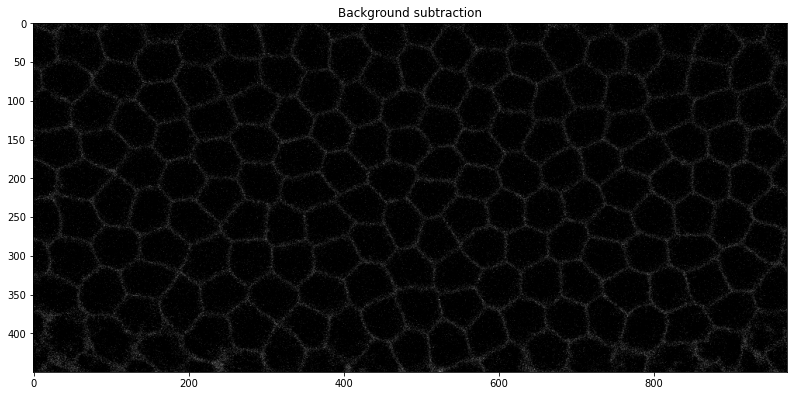

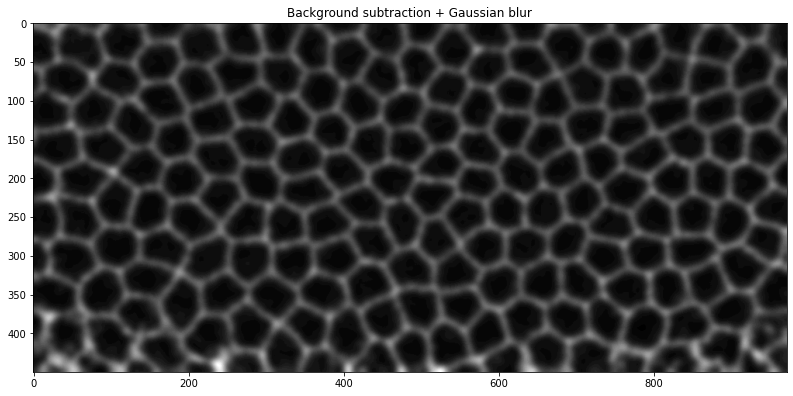

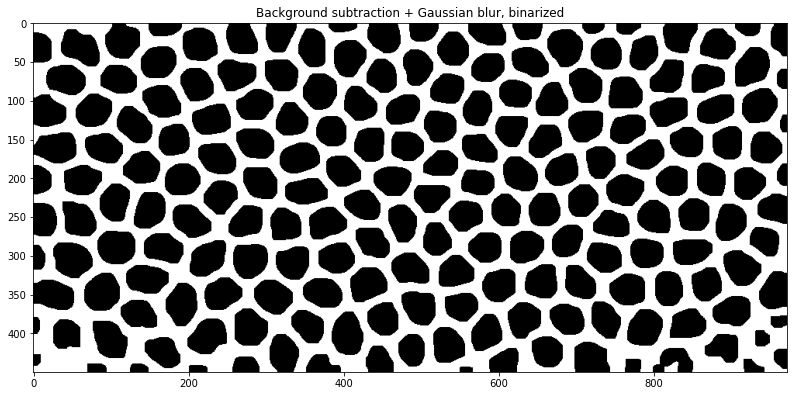

In [ ]:
# TESTING: rescale original image to use full [0 255] range
emb1raw = emb1.copy()
emb1 = (emb1raw-np.min(emb1raw))/np.max(emb1raw-np.min(emb1raw))*255
emb1 = emb1.astype(np.uint8) # Back to uint8 type

# Subtract background
emb1_bgSub = cv2.subtract(emb1, cv2.GaussianBlur(emb1,(251,251),0), np.zeros(np.size(emb1)))
plt.imshow(emb1_bgSub,'gray'), plt.title('Background subtraction')
plt.show()

# Apply a Gaussian blur
emb1_bgSub_blur = cv2.GaussianBlur(emb1_bgSub,(25,25),0)
plt.imshow(emb1_bgSub_blur,'gray'), plt.title('Background subtraction + Gaussian blur')
plt.show()

# Threshold
emb1_thresh, emb1_bin = cv2.threshold(emb1_bgSub_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# emb1_thresh, emb1_bin = cv2.threshold(emb1_bgSub_blur,2*np.mean(emb1_bgSub_blur),255,cv2.THRESH_BINARY)
emb1_bin_closed = cv2.morphologyEx(emb1_bin, cv2.MORPH_CLOSE, np.ones((11,11),np.uint8))
plt.imshow(emb1_bin_closed,'gray'), plt.title('Background subtraction + Gaussian blur, binarized')
plt.show()

In [ ]:
px.imshow(emb1_bin_closed)

### Step three - thin the segmented membranes to single-pixel thickness

The term for this in image processing is 'skeletonizing': an object (here, the cell membranes) will be shrunk in width while maintaining its connectivity (i.e. number of holes). Note that this is different than erosion, which shrinks objects in all directions and can introduce gaps in them.

cv2 does not have a default skeletonize function and writing one from scratch isn't really the point of this exercise, so we'll use one from a different image processing library, sci-kit image (skimage).

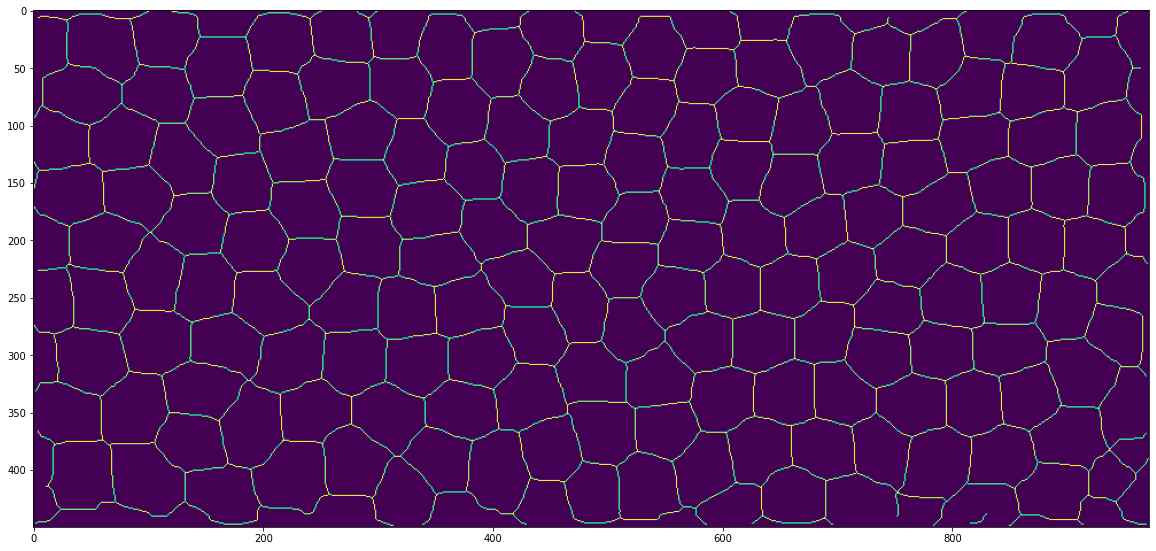

In [ ]:
from skimage.morphology import skeletonize
skelled1 = skeletonize(emb1_bin_closed/255)
# px.imshow(cv2.morphologyEx(skelled, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))))
# px.imshow(skelled) # Sometimes displaying skeletonized results this way is visually buggy - try zooming in if it looks like membranes are missing

plt.imshow(skelled1)
plt.gcf().set_size_inches(20, 20)
plt.show()

### Step four - try the same steps on a more complicated image

The following image is from the same movie of a developing embryo, taken a bit later. Segmentation will be harder for this one - see if you can guess why from looking at the image.

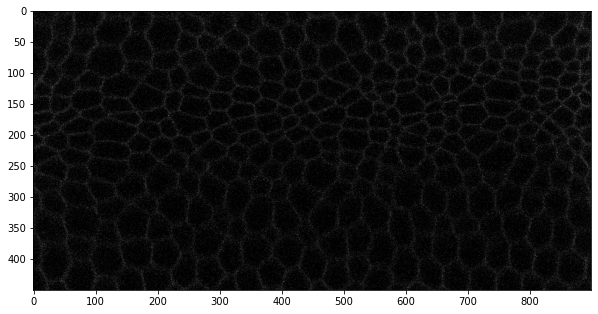

In [ ]:
fname = '/content/gdrive/MyDrive/QMW2023_imageAnalysisWorkshop/embryo_membranes_t33.tif'
emb2 = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
plt.autoscale() # Autoscale the plot so the dimmest pixel is displayed as 0 and the brightest as 255.
plt.imshow(emb2,cmap='gray')
plt.gcf().set_size_inches(10, 10)
plt.show()

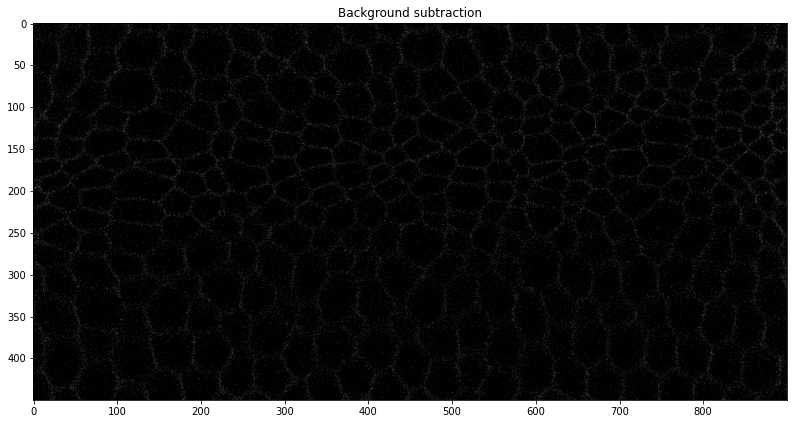

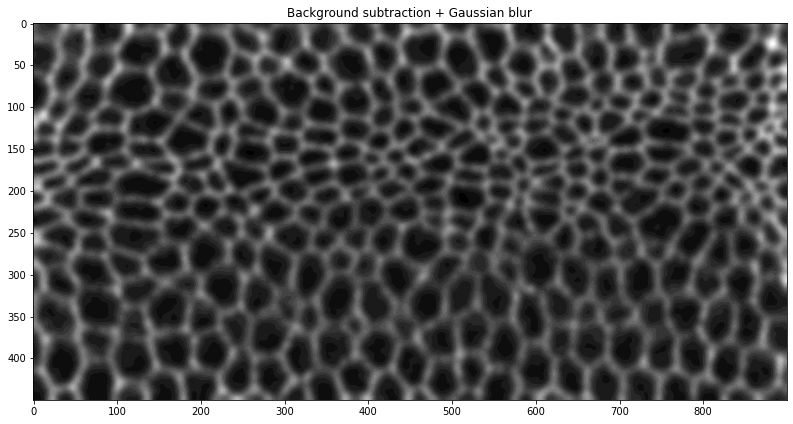

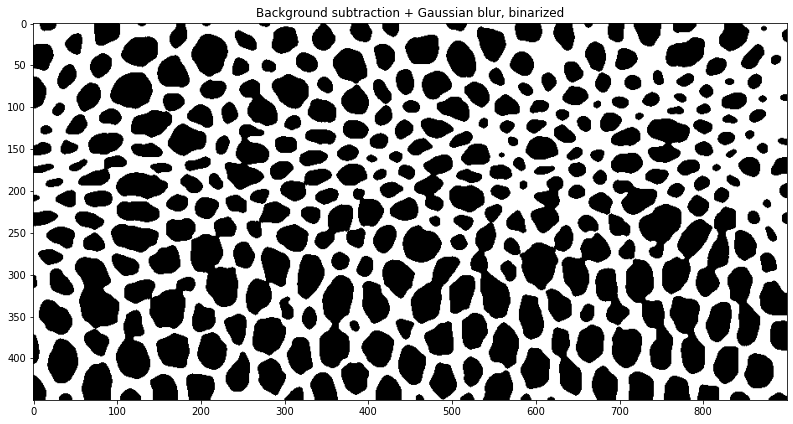

In [ ]:
# TESTING: rescale original image to use full [0 255] range
emb2raw = emb2.copy()
emb2 = (emb2raw-np.min(emb2raw))/np.max(emb2raw-np.min(emb2raw))*255
emb2 = emb2.astype(np.uint8) # Back to uint8 type

# Subtract background
bg = 1.0*cv2.GaussianBlur(emb2,(251,251),0) # If you want to increase / weaken background subtraction, change '1.0' in front to a higher/lower value
emb2_bgSub = cv2.subtract(emb2, bg.astype(np.uint8), np.zeros(np.size(emb2)))
# emb2_bgSub = cv2.subtract(emb2, cv2.GaussianBlur(emb2,(251,251),0), np.zeros(np.size(emb2)))
plt.imshow(emb2_bgSub,'gray'), plt.title('Background subtraction')
plt.show()

# Apply a Gaussian blur
emb2_bgSub_blur = cv2.GaussianBlur(emb2_bgSub,(25,25),0)
plt.imshow(emb2_bgSub_blur,'gray'), plt.title('Background subtraction + Gaussian blur')
plt.show()

# Threshold
emb2_thresh, emb2_bin = cv2.threshold(emb2_bgSub_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# emb2_thresh, emb2_bin = cv2.threshold(emb2_bgSub_blur,2*np.mean(emb2_bgSub_blur),255,cv2.THRESH_BINARY)
closekern2a = np.ones((7,7),np.uint8)
closekern2b = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
emb2_bin_closed = cv2.morphologyEx(emb2_bin, cv2.MORPH_CLOSE, closekern2b)
plt.imshow(emb2_bin_closed,'gray'), plt.title('Background subtraction + Gaussian blur, binarized')
plt.show()

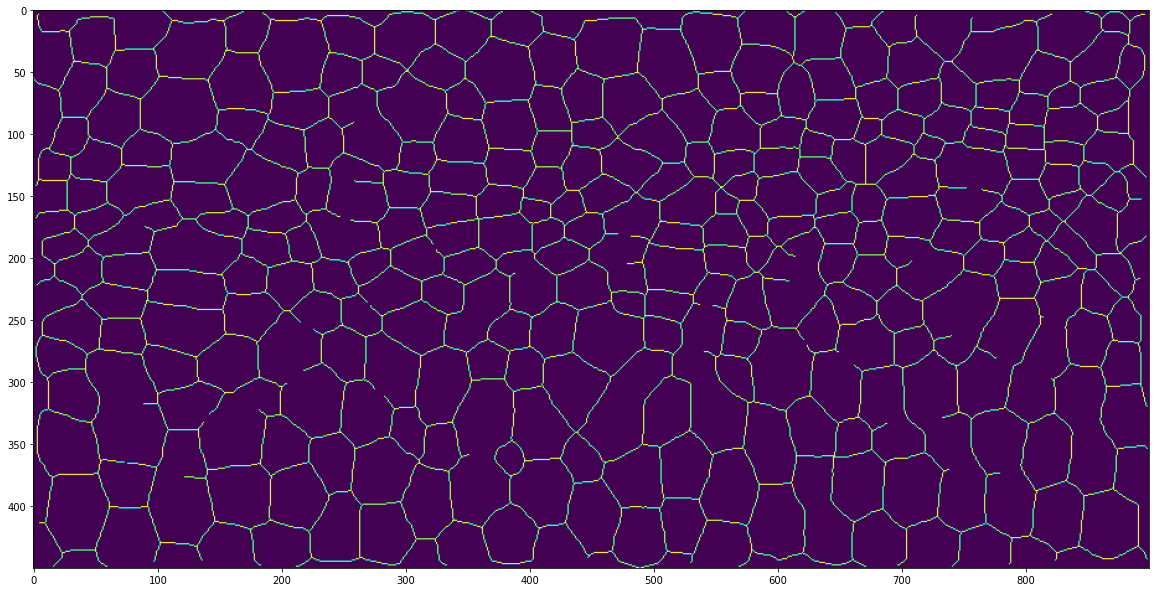

In [ ]:
skelled2 = skeletonize(emb2_bin_closed/255)
# px.imshow(cv2.morphologyEx(skelled, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))))
# px.imshow(skelled) # Sometimes displaying skeletonized results this way is visually buggy - try zooming in if it looks like membranes are missing

plt.imshow(skelled2)
plt.gcf().set_size_inches(20, 20)
plt.show()

In [ ]:
# TESTING - delete this later
# import matplotlib.image
# cv2.imwrite("content/embryo_t33_skel.tif", skelled2.astype(np.uint8))
# import tifffile as tiff
# tiff.imsave('content/temp.tiff', skelled2.astype(np.uint8))

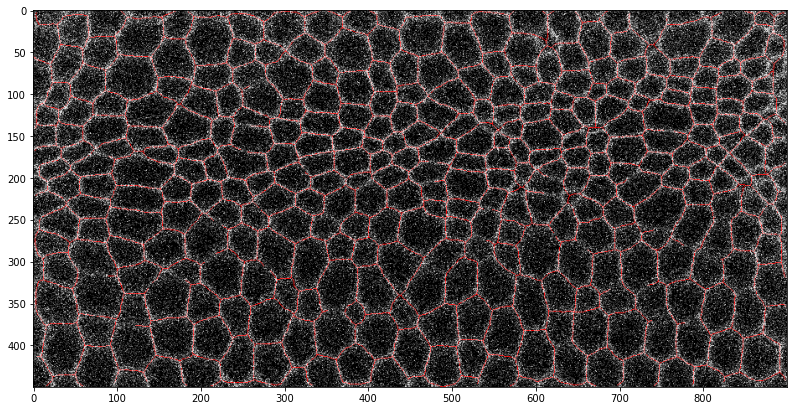

In [ ]:
# merged = cv2.merge([255*skelled2.astype(np.uint8), emb2, np.zeros(skelled2.shape,np.uint8)]) # Green data, red skeleton
emb2scale = emb2*5.5
emb2scale = emb2scale.astype(np.uint8)
# merged = cv2.merge([cv2.add(emb2,255*skelled2.astype(np.uint8)), emb2, emb2]) # Gray data, red skeleton
merged = cv2.merge([cv2.add(emb2scale,255*skelled2.astype(np.uint8)), emb2scale, emb2scale]) # Gray data, red skeleton
plt.imshow(merged)
plt.show()

## Exercise set #3 - Identifying, segmenting, and measuring sizes of objects/cells using 'regionprops'

This exercise set includes:
- Associating a label to each individual object ('connected-components labeling')
- Measuring properties from each object, as well as number of objects (e.g. number of coins in the first exercise or number of cells in the field of view in the second).

### Part one: getting familiar with regionprops using the coin example

Let's start with the coin example. Here, counting by eye would be perfectly reasonable, but imagine you have something like this for tens of images and want to get a count for each. Plus, we'll measure things like size.

The measurement technique demonstrated here starts from a binary image, so use the best version of the segmentation you got for the coins in Exercise 1.

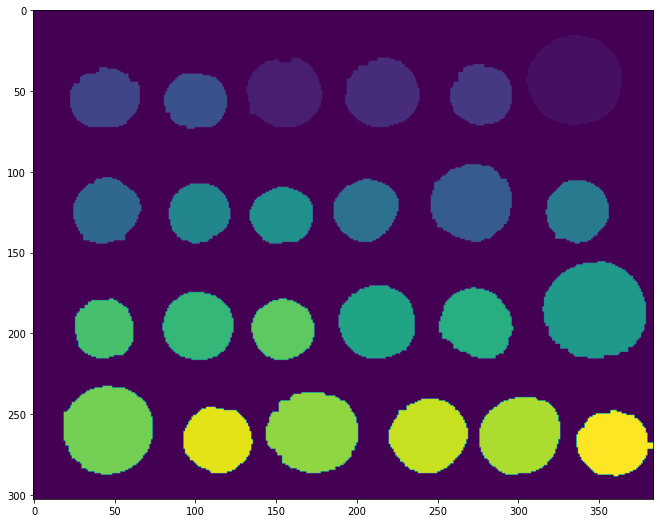

There are 24 coins.
Coin            Size (pixels)   Area (pixels^2) Centroid x      Centroid y      Aspect Ratio
1               2571            2571.0          43.6            334.7           1.057     
2               1580            1580.0          51.4            155.2           1.098     
3               1536            1536.0          51.5            215.6           1.085     
4               1135            1135.0          52.7            276.8           1.021     
5               1262            1262.0          55.0            44.0            1.202     
6               1065            1065.0          56.3            100.3           1.139     
7               1877            1877.0          119.1           270.8           1.067     
8               1295            1295.0          124.3           44.7            1.073     
9               1192            1192.0          123.8           205.3           1.090     
10              1172            1172.0          124.6           336.

In [ ]:
coinImg = improved

# Object labels and counts
labelarray = measure.label(coinImg) # Associates a different numerical label to each blob of foreground pixels
plt.imshow(labelarray) # Not super informative, but good to check you don't have two merged objects
plt.show()

# More detailed data, using a fancier print function to make a rough table
print('There are %d coins.' % np.max(labelarray))
props = measure.regionprops(labelarray) # Lots of properties, stored in a (number of coins)-element list
print ("{:<15} {:<15} {:<15} {:<15} {:<15} {:<10}".format('Coin','Size (pixels)','Area (pixels^2)', 
                                                         'Centroid x','Centroid y','Aspect Ratio'))
for prop in props:
    cent = np.round(prop.centroid,1)
    ar = prop.major_axis_length/prop.minor_axis_length
    print("{:<15} {:<15} {:<15.1f} {:<15.1f} {:<15.1f} {:<10.3f}".format(prop.label, prop.area, prop.area, cent[0], cent[1], ar))

### Part two: measuring cell areas from a membrane label image

That wasn't the most interesting example, but now that you know the process, you can start getting useful data from segmented images of biological systems. Let's take another look at the *Drosophila* embryo image. We'll use the early image with relatively uniform cell sizes here, but try the more complicated ones if you'd like.

The coin example is straightforward, since you had a binary image with bright regions corresponding to the objects of interest. The cell membrane image is different, though: we care about the *cells*, not their membranes, so you'll have to figure out a way to use the membranes to measure the cells.

In [ ]:
embImg = 255*(1-np.ndarray.astype(skelled1,'uint8')) # Invert image. Skeletonized output is Boolean, which converts to 0 or 1, so scale back to 255
dx = 0.1312 # µm per pixel for this image. Needed to get cell areas in physical units rather than pixel units

# Object labels and counts
labelarray = measure.label(embImg,connectivity=1)

# More detailed data, using a fancier print function to make a rough table
print('There are %d cells.' % np.max(labelarray))
props = measure.regionprops(labelarray)
print ("{:<15} {:<15} {:<15} {:<15} {:<10}".format('Cell','Size (µm^2)', 
                                                         'Centroid x','Centroid y','Aspect Ratio'))
for prop in props:
    cent = np.round(prop.centroid,1)
    ar = prop.major_axis_length/prop.minor_axis_length
    print("{:<15} {:<15.3f} {:<15.1f} {:<15.1f} {:<10.3f}".format(prop.label, prop.area*dx*dx, cent[0], cent[1], ar))

There are 154 cells.
Cell            Size (µm^2)     Centroid x      Centroid y      Aspect Ratio
1               116.449         54.6            54.4            1.769     
2               22.550          8.8             173.8           3.888     
3               118.084         18.4            351.6           6.325     
4               102.609         11.4            621.0           11.154    
5               193.290         167.9           931.0           3.508     
6               43.034          27.8            215.1           1.104     
7               48.370          30.5            60.4            1.354     
8               39.212          32.2            360.1           1.261     
9               45.530          31.2            685.5           1.106     
10              39.126          27.7            882.0           1.206     
11              38.747          33.4            541.0           1.097     
12              37.508          37.5            786.4           1.342     
13

In [ ]:
px.imshow(labelarray)

47.15364804155845
41.67606438054055


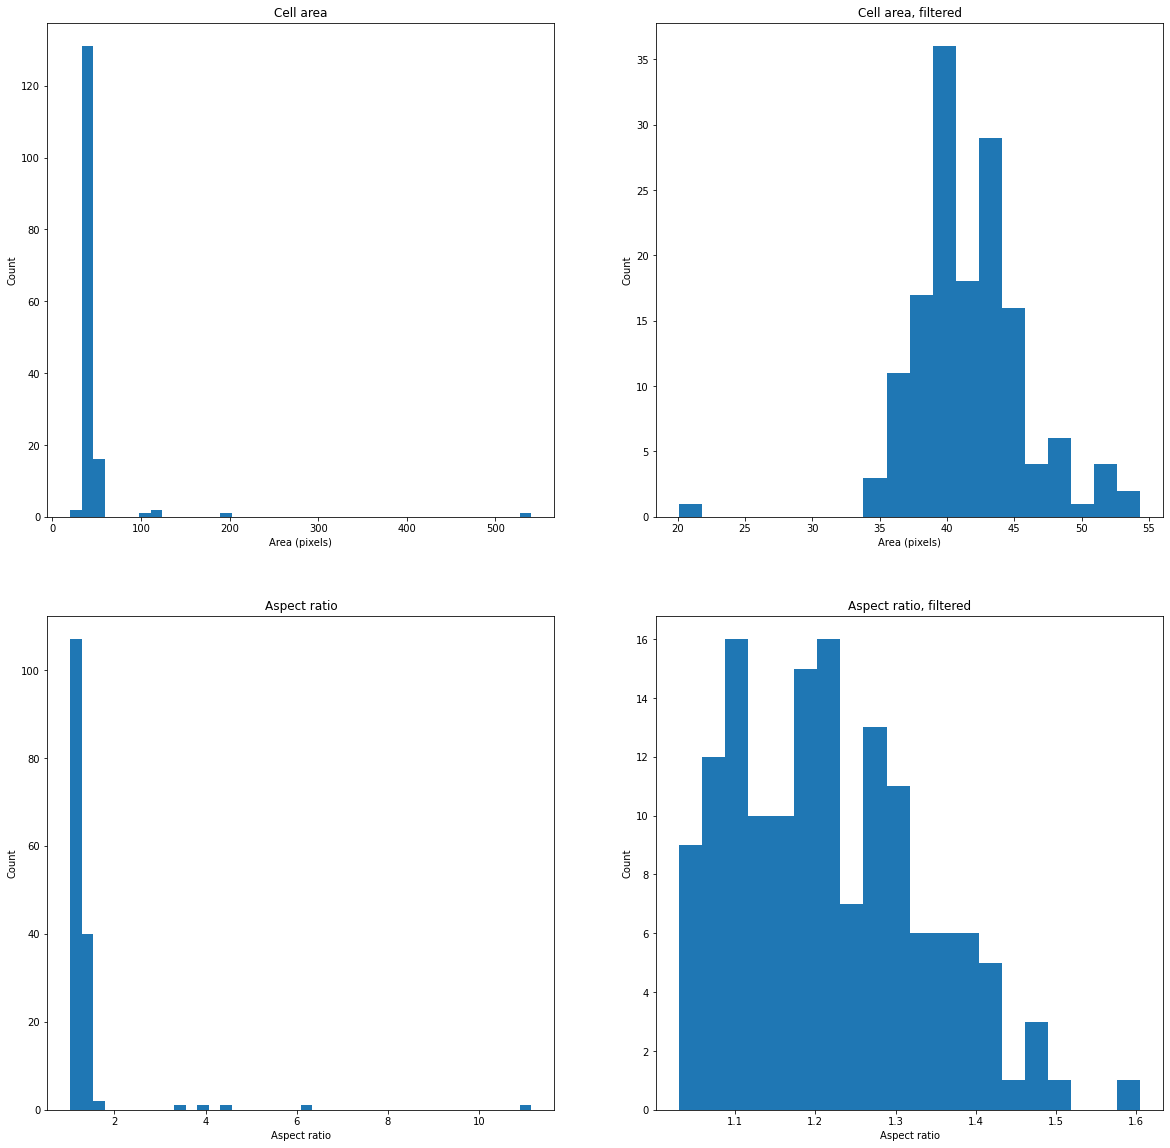

In [ ]:
# More detailed data, with some summary statistics of size (that table is unwieldy to read)
props = measure.regionprops(labelarray) # Lots of properties, stored in a (number of cell)-element list
sizes = np.array([props[i].area*dx*dx for i in range(len(props))])
ars = np.array([props[i].major_axis_length/props[i].minor_axis_length for i in range(len(props))])
avgsize = np.mean(sizes) # Gives average size
print(avgsize)

# Slight filtering to remove the larger background regions and at least one of the merged cells
cleansizes = sizes[(sizes < 3200*dx*dx) & (ars < 3)] # Somewhat empirical, from looking at image. The largest single cells are ~3000 pixels
cleanars = ars[(sizes < 3200*dx*dx) & (ars < 3)]
cleanavgsize = np.mean(cleansizes) # Gives average size
print(cleanavgsize)

plt.subplot(2,2,1)
plt.hist(sizes, bins=40)
plt.title('Cell area')
plt.ylabel('Count')
plt.xlabel('Area (pixels)')
plt.gcf().set_size_inches(5, 5)

plt.subplot(2,2,2)
plt.hist(cleansizes, bins=20)
plt.title('Cell area, filtered')
plt.ylabel('Count')
plt.xlabel('Area (pixels)')
plt.gcf().set_size_inches(5, 5)

plt.subplot(2,2,3)
plt.hist(ars, bins=40)
plt.title('Aspect ratio')
plt.ylabel('Count')
plt.xlabel('Aspect ratio')
plt.gcf().set_size_inches(5, 5)

plt.subplot(2,2,4)
plt.hist(cleanars, bins=20)
plt.title('Aspect ratio, filtered')
plt.ylabel('Count')
plt.xlabel('Aspect ratio')
plt.gcf().set_size_inches(5, 5)

plt.gcf().set_size_inches(20, 20)
plt.show()

## If you've finished all of the examples...
Good job! Try to go through the membane segmentation steps and improve your segmentation. Think about what steps you can change (e.g. kernel sizes or morphological operations). We've also included a few other images to try segmenting in the same folder as the membrane images from Exercise 2. If you want a challenge that involves thinking about blur radii, threshold levels, and edge detection, see if you can get a binary image of the coins that picks out the person on the top right coin.

We've also added some images of nuclei from the *Drosophila* embryo. Try to segment those - it should be somewhat similar to the coin example, but with actual biological data.

If you're happy with the segmentations, below is a brief description of FIJI, a great free tool for visualizing and analyzing images in biology. While this workshop is mainly Python-based, FIJI is such a useful and versatile package that it's worth exploring if you have extra time. Much of the image analysis work done in our lab involves FIJI for at least part of the process.

# FIJI

[FIJI](https://imagej.net/software/fiji/) (***F***IJI ***I***s ***J***ust ***I***mageJ), and its earlier incarnation, ImageJ, are excellent, free, and open-source tools for viewing images and performing a huge variety of processing/analysis operations on them.

FIJI comes with a fairly comprehensive set of image processing tools, but one nice feature of FIJI is the multitude of *plugins* available to provide even more functions. One of these, called MorphoLibJ, is a great resource for image segmentation.

## Installing FIJI and exploring a little

To install FIJI, please follow the [installation instructions](https://imagej.net/software/fiji/downloads). Everything you need to get started should be included in the download and installation instructions on this page.

* Download any of the other images in the 'QMW2023_imageAnalysisWorkshop' folder.
* Open the FIJI application. You should see a menu bar somewhere on your screen. FIJI is somewhat overwhelming and hard to navigate at first (the dropdown menus can have dropdown menus that sometimes have dropdown menus, and so on...), but take a look around too see what options there are.
* Locate the image file you downloaded. Drag and drop it onto the FIJI bar. Alternatively, Go to **File > Open...** to select your image file from the navigator that opens.
* You should now see the image with sliders at the bottom if the image has three or more dimensions. For images, there are generally five possible dimensions:
  * Width
  * Height
  * Depth (z)
  * Time (t)
  * Color / channel (c) - for example, an image with a nucleus channel and a membrane channel will have two colors.
    * Note that files in RGB format are only read as one channel. You can get back to three channels, one per color, using **Image > Color > Split Channels** and **Image > Color > Merge Channels**.
* Play around with the sliders and see how the image changes. If you opened a dataset with a time dimension, click the small triangle next to the bar at the bottom (or hit the '\\' key) to start or stop the movie.
* FIJI always shows you xy-planes, while the bars at the bottom let you step through the c, z, or t dimensions.
* Explore a little to get an idea of what FIJI allows you to do. In particular, the **Image > Stacks** commands have some useful functions for visualizing data, while the **Process** menu has nice functions to smooth, denoise, and so on.

Try opening 'embryoVentralFurrow_myosin_membrane_live.tif' from the shared Google Drive folder in FIJI (you'll probably have to download it first). It has five dimensions, so play around with it to see how the image changes over time and depth. The image is somewhat dim, so you'll need to adjust the display settings first: go to **Image > Adjust > Brightness/Contrast**, then click 'Auto' in the box that appears. This should brighten the image some. Go to the other channel (move the bar in the image next to the letter 'c' to the right) and adjust the brighness/contrast there, too. You should now be able to see both myosin (first channel) and membranes (second channel).